# [Multilingual text classification with BERT](https://github.com/nlptown/nlp-notebooks/blob/master/Multilingual%20text%20classification%20with%20BERT.ipynb)

This code was inspired by https://github.com/nlptown/nlp-notebooks/blob/master/Multilingual%20text%20classification%20with%20BERT.ipynb

In this notebook we'll build a multilingual text classification model with [BERT](https://arxiv.org/abs/1810.04805). To this goal, we can use a multilingual BERT model:

- BERT-multilingual was pretrained on monolingual text in 104 languages. A wordpiece tokenizer is used to map these texts to a shared vocabulary.
- Because of this multilingual pre-training phase, BERT-multilingual can be finetuned in any of these languages to perform a task in the same language.
- However, BERT-multilingual also has cross-lingual capabilities. This means it can generalize to a language it was not finetuned on.

## Task

As usual, we start by splitting up the data in a training, development and testing portion.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = '/content/drive/MyDrive/dataset_ita_eng_cleaned.csv'
df = pd.read_csv(file_path, header = None)
df.head(10)

,0,1,2
0,UsNB_SOM2_DOC1_0012,refresh tecnologico della som che prevede o d...,Requirement
1,UsNB_SOM2_DOC1_0013,realizzazione di una seconda sala server pres...,Requirement
2,UsNB_SOM2_DOC1_0014,realizzazione di una seconda sala operativa d...,Requirement
3,UsNB_SOM2_DOC1_0015,porting del sw alstom sulla nuova infrastrutt...,Requirement
4,UsNB_SOM2_DOC1_0016,spostamento o sostituzione di software ad es ...,Requirement
5,UsNB_SOM2_DOC1_0017,"modifiche di rete rete sv l , attivazione gia...",Requirement
6,UsNB_SOM2_DOC1_0018,interfacciamento dei sistemi alstom con una n...,Requirement
7,UsNB_SOM2_DOC1_0019,integrazione tra sistemi alstom e applicazion...,Requirement
8,UsNB_SOM2_DOC1_0020,inserimento di misure di cybersecurity nella ...,Requirement
9,UsNB_SOM2_DOC1_0021,"modifiche da attuare su scada l l l , compres...",Requirement


In [3]:
import re
def clean_text(text):

    text = text.lower()

    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)

    punctuation = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuation:
        text = text.replace(p,'')

    # reduce text to 100 words max - should be enough
    # to determine the label
    text = text.split(" ")
    if len(text) > 100:
        text = text[:100]
    text = " ".join(text)

    return text

df[1] = df[1].apply(lambda x: clean_text(x))

df.head()

,0,1,2
0,UsNB_SOM2_DOC1_0012,refresh tecnologico della som che prevede o d...,Requirement
1,UsNB_SOM2_DOC1_0013,realizzazione di una seconda sala server pres...,Requirement
2,UsNB_SOM2_DOC1_0014,realizzazione di una seconda sala operativa d...,Requirement
3,UsNB_SOM2_DOC1_0015,porting del sw alstom sulla nuova infrastrutt...,Requirement
4,UsNB_SOM2_DOC1_0016,spostamento o sostituzione di software ad es ...,Requirement


Next we map each of the labels in our data to an index.

In [4]:
target_names = df[2].unique().tolist()
label2idx = {label: idx for idx, label in enumerate(sorted(target_names))}
print(label2idx)

{'Information': 0, 'Requirement': 1}


## Preparation

### Initializing a model

We're going to use one of BERT's multilingual models.

In [5]:
from transformers import BertTokenizer

BERT_MODEL = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
import torch
from transformers import BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### Preparing the data

Next we need to prepare our data for BERT. We'll present every document as a BertInputItem, which contains all the information BERT needs: the input ids (the ids of the word pieces in the text), the input mask (which masks out padding tokens), the segment ids (which tell BERT how many segments are present in the input, and where these segments are) and the label id (the id of the label for the item).

To speed up the training process, we set the maximum sequence length to 100. This means we'll cut off our texts after 100 wordpiece tokens.

Finally, we'll also create a DataLoader for each of our data sets. These dataloaders will feed our data to the model during training, development and testing. They take care of presenting batches of the right size and shuffling the data when necessary.

In [7]:
texts = df[1].tolist()
labels = df[2].tolist()

In [8]:
# Split the data into training validatoon and test sets (70-15-15)
from sklearn.model_selection import train_test_split

train_texts, _texts, train_labels, _labels = train_test_split(texts, labels,
                                                    random_state=42, test_size=0.3)
test_texts, val_texts, test_labels, val_labels = train_test_split(_texts, _labels,
                                                    random_state=42, test_size=0.5)

In [9]:
import logging
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s - %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

MAX_SEQ_LENGTH=100

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer, verbose=0):
    """Loads a data file into a list of `InputBatch`s."""

    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))


    return input_items

def get_data_loader(features, max_seq_length, batch_size=8, shuffle=True):

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    return dataloader


train_features = convert_examples_to_inputs(train_texts, train_labels,
                                            label2idx, MAX_SEQ_LENGTH, tokenizer, verbose=10)

dev_features = convert_examples_to_inputs(val_texts, val_labels,
                                          label2idx, MAX_SEQ_LENGTH, tokenizer)

test_features = convert_examples_to_inputs(test_texts, test_labels,
                                            label2idx, MAX_SEQ_LENGTH, tokenizer)


train_dataloader = get_data_loader(train_features, MAX_SEQ_LENGTH, shuffle=True)
dev_dataloader = get_data_loader(dev_features, MAX_SEQ_LENGTH, shuffle=False)
test_dataloader = get_data_loader(test_features, MAX_SEQ_LENGTH, shuffle=False)

### Evaluation method

Our evaluation method, too, is the same as before. It takes as input a model and dataloader and returns the loss, the correct labels for the data and the labels that were predicted for the model. This evaluation method will be used several times in our experiment:

- During training we will use it to evaluate the loss on the development data. If this loss stops improving, we will stop training.
- When we're done training we will use it to evaluate the model's performance on the held-out test data.

In [10]:
import tqdm.notebook as tqdm

def evaluate(model, dataloader, device):

    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    model.to(device)
    for step, batch in enumerate(tqdm.tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=input_mask,
                              token_type_ids=segment_ids, labels=label_ids)

        eval_loss += outputs.loss.item()
        nb_eval_steps += 1

        predictions = np.argmax(outputs.logits.to('cpu'), axis=1)
        true_labels = label_ids.to('cpu').numpy()

        predicted_labels += list(predictions)
        correct_labels += list(true_labels)

    eval_loss = eval_loss / nb_eval_steps

    predicted_labels = np.array(predicted_labels)
    correct_labels = np.array(correct_labels)
    eval_accuracy = np.mean(predicted_labels == correct_labels)

    return eval_loss, eval_accuracy

#Training

We're finally ready to train our model. At each epoch, we're going to train it on our training data and evaluate it on the development data. We keep a history of the loss, and stop training when the loss on the development set doesn't improve for a certain number of steps. Whenever the development loss of our model improves, we save it.

In [11]:
import torch
import os
from tqdm import trange
import tqdm.notebook as tqdm
from transformers import AdamW, get_linear_schedule_with_warmup

def train(model, train_dataloader, dev_dataloader, output_model_file="/content/drive/MyDrive/BERT_info_req.bin",
          num_train_epochs=20, patience=2, gradient_accumulation_steps=1, max_grad_norm=5,
          warmup_proportion=0.1, batch_size=8, learning_rate=5e-5):

    num_train_steps = int(len(train_texts) / batch_size / gradient_accumulation_steps * num_train_epochs)
    num_warmup_steps = int(warmup_proportion * num_train_steps)

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, correct_bias=False,no_deprecation_warning=True)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)
    loss_history = []
    no_improvement = 0
    for _ in trange(int(num_train_epochs), desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0
        for step, batch in enumerate(tqdm.tqdm(train_dataloader, desc="Training iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch

            outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
            loss = outputs[0]

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps

            loss.backward()

            tr_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

        dev_loss, dev_accuracy = evaluate(model, dev_dataloader, "cuda")

        print("Loss history:", loss_history)
        print("Dev loss:", dev_loss)
        print("Dev accuracy:", dev_accuracy)

        if len(loss_history) == 0 or dev_loss < min(loss_history):
            no_improvement = 0
            model_to_save = model.module if hasattr(model, 'module') else model
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("No improvement on development set. Finish training.")
            break

        loss_history.append(dev_loss)

    return output_model_file

In [12]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels = len(label2idx))
model.to(device)
model_file_name = train(model, train_dataloader, dev_dataloader, gradient_accumulation_steps=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training iteration:   0%|          | 0/1068 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/229 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.5729230723006236
Dev accuracy: 0.746586564718733


Epoch:   5%|▌         | 1/20 [01:04<20:33, 64.94s/it]

Training iteration:   0%|          | 0/1068 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/229 [00:00<?, ?it/s]

Loss history: [0.5729230723006236]
Dev loss: 0.41732475223369475
Dev accuracy: 0.8263244128891316


Epoch:  10%|█         | 2/20 [02:03<18:24, 61.35s/it]

Training iteration:   0%|          | 0/1068 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/229 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [03:00<16:49, 59.39s/it]

Loss history: [0.5729230723006236, 0.41732475223369475]
Dev loss: 0.43941898476413765
Dev accuracy: 0.8241398143091206


Training iteration:   0%|          | 0/1068 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/229 [00:00<?, ?it/s]

Epoch:  15%|█▌        | 3/20 [03:57<22:27, 79.25s/it]

Loss history: [0.5729230723006236, 0.41732475223369475, 0.43941898476413765]
Dev loss: 0.4306160300303104
Dev accuracy: 0.8405243036592026
No improvement on development set. Finish training.


# Testing

In [13]:
from transformers import BertForSequenceClassification, BertTokenizer

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels = len(label2idx))
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torch
model.load_state_dict(torch.load('/content/drive/MyDrive/BERT_info_req.bin'))

<All keys matched successfully>

In [15]:
import tqdm.notebook as tqdm
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
device = "cuda"
predicted_labels, correct_labels = [], []
model.to(device)

for step, batch in enumerate(tqdm.tqdm(test_dataloader, desc="Testing iteration")):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, segment_ids, label_ids = batch

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=input_mask,
                          token_type_ids=segment_ids, labels=label_ids)

    predictions = np.argmax(outputs.logits.to('cpu'), axis=1)
    true_labels = label_ids.to('cpu').numpy()

    predicted_labels += list(predictions)
    correct_labels += list(true_labels)

predicted_labels = np.array(predicted_labels)
correct_labels = np.array(correct_labels)

Testing iteration:   0%|          | 0/229 [00:00<?, ?it/s]

In [16]:
print(classification_report(correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       563
           1       0.84      0.92      0.88      1268

    accuracy                           0.83      1831
   macro avg       0.81      0.77      0.78      1831
weighted avg       0.82      0.83      0.82      1831



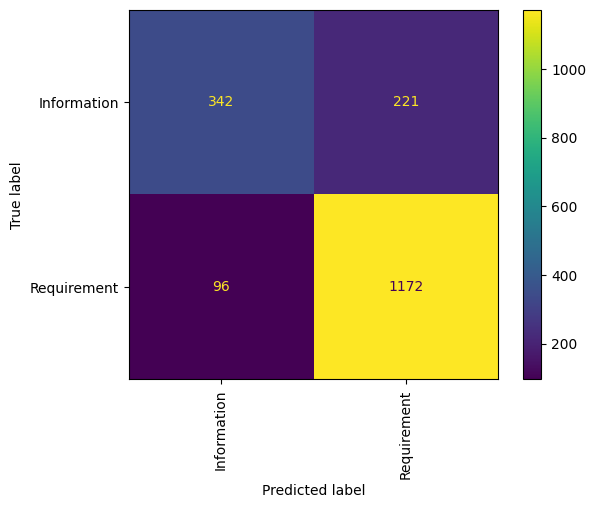

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(correct_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=label2idx.keys())
disp.plot()
disp.ax_.set_xticklabels(label2idx.keys(), rotation=90)
plt.show()